# Snapshot Ensembles


This is a partial implementation and demo of concepts explained in paper

`Snapshot Ensembles: Train 1, get M for free`

Gao Huang, Yixuan Li, Geoff Pleiss Cornell University
Zhuang Liu Tsinghua University
John E. Hopcroft, Kilian Q. Weinberger Cornell University

https://arxiv.org/abs/1704.00109 - 2017

> Ensembles of neural networks are known to be much more robust and accurate than individual networks. However, training multiple deep networks for model averaging is computationally expensive. In this paper, we propose a method to obtain the seemingly contradictory goal of ensembling multiple neural networks at no additional training cost. We achieve this goal by training a single neural network, converging to several local minima along its optimization path and saving the model parameters. To obtain repeated rapid convergence, we leverage recent work on cyclic learning rate schedules. The resulting technique, which we refer to as Snapshot Ensembling, is simple, yet surprisingly effective. We show in a series of experiments that our approach is compatible with diverse network architectures and learning tasks. It consistently yields lower error rates than state-of-the-art single models at no additional training cost, and compares favorably with traditional network ensembles. On CIFAR-10 and CIFAR-100 our DenseNet Snapshot Ensembles obtain error rates of 3.4% and 17.4% respectively.
   
In deep learning competitions, it happens quite often that winners use ensemble techniques to build several models using different learning initializations or scheduler to build several models that are mixed together. This technique is efficient as it allows to reach different local minima in the optimization path covering more cases and thus reducing error rates. But it is crazy expensive in terms of resources and time (n ensembles mean n trainings). This is exactly not the way I want that we solve those issues.

Snapshot ensemble idea is to build an ensemble of networks by reaching multiple local minima in a single training. This is achieved by using a cyclic learning rate scheduler that:

- divides the whole training process ($T$ iterations) into several cycles ($M$)
- during each cycle, fast reduces learning rate from initial value at every iteration (in the paper, at batch level, not epoch) to lead optimizer to a local minimum
- hard-reset learning rate at end of cycle back to initial value (or with a progressive decrease) to let optimizer _escape local bath_ and find another local minimum.

At the end of training, we keep the best models found in the last 2 or 3 cycles making our snapshot ensemble of models that should cover more error cases than single best model.

![SGD_vs_Snapshot_Ensemble](media/snapshot_ensemble.png)

Let's test that idea...

> This code is licensed under Apache2

## Initialize some imports

In [26]:
import os
import sys
import time
from pathlib import Path
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio

from tensorboardX import SummaryWriter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Tensorboard plot data (yes you can)

In [2]:
from utils.tensorboard import tensorboard_event_accumulator

tensorboard_file = "./tf_logs/snapshot_ensemble/events.out.tfevents.1552256696.b127a0f62e91"
ea = tensorboard_event_accumulator(tensorboard_file)

## Snapshot Ensemble Cyclic Cosine Annealing Scheduler

In the paper, the cyclic scheduler uses a custom version of Cosine Cyclic Annealing (Ilya Loshchilov and Frank Hutter. Sgdr: Stochastic gradient descent with restarts. https://arxiv.org/abs/1608.03983 2016) 

$$
\begin{aligned}
\alpha(t) = \frac {\alpha_{0}} {2}(cos (\pi * \frac {mod(t - 1, \lceil\frac {T} {M}\rceil} {\frac {T} {M}}) + 1)
\end{aligned}
$$

where
- $\alpha_{0}$ is the initial learning rate
- M number of cycles
- T total number of iterations (nb_batches_per_epoch * nb_epochs)

### Cyclic Learning rate plot

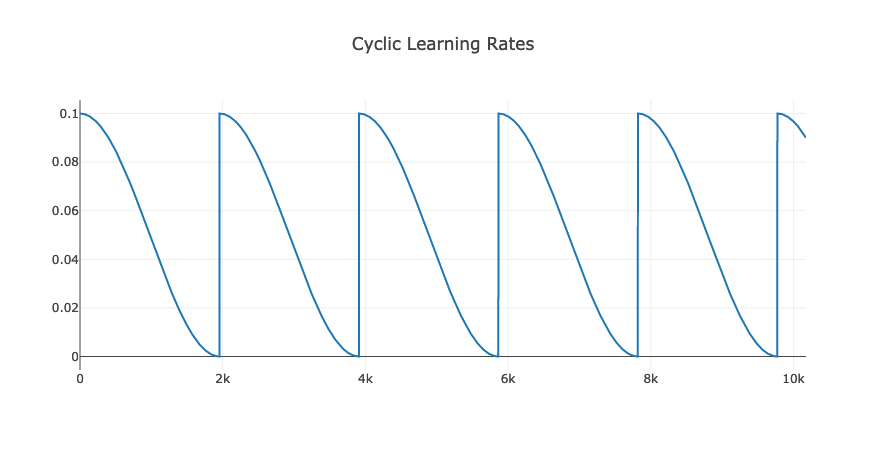

In [6]:
cyclic_lrs = ea.Scalars("cur_lr")
layout = go.Layout(
    title='Cyclic Learning Rates'
)
data = [
    go.Scatter(
        x=list(map(lambda l: l.step, cyclic_lrs)),
        y=list(map(lambda l: l.value, cyclic_lrs)),
        name="cyclic_lrs")
]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='cyclic_lrs')

### Implementation

This implementation is a mix of the formula in:
- Snapshot Ensembles: Train 1, get M for free https://arxiv.org/abs/1704.00109
- SGDR : Stochastic Gradient Descent with Warm Restarts https://arxiv.org/abs/1608.03983


$$
\begin{aligned}
lr(t) = {lr}_{min} + \frac {{lr}_{max} - {lr}_{min}} {2}(cos (\pi * \frac {mod(t - 1, \lceil\frac {T} {M}\rceil} {\frac {T} {M}}) + 1)
\end{aligned}
$$

where

- $lr_{max}$ is the initial cycle learning rate
- $lr_{min}$ is the final cycle learning rate
- M number of cycles
- T total number of iterations (nb_batches_per_epoch * nb_epochs)

In [51]:
# %load snapshot_ensemble_scheduler.py
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWithRestartScheduler(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cyclic cosine annealing schedule
    :math:`T` is total number of steps in the training (:math:`total_epochs * steps_per_epoch`),
    :math:`M` is the number of cycles wanted in the training,
    :math:`lr_max` is the initial cycle lr and :math:`lr_min` the final cycle lr.
    
    At next cycles, new lr is computed with lambda compute_lr_min_max from from lr_min, lr_max, last_epoch and cur_cycle.

    .. math::

        \alpha(t) = {\lr_min} + \frac ({\lr_max} - {\lr_min}) {2} (cos (\pi * \frac {mod(t - 1, \lceil\frac {T} {M}\rceil} {\frac {T} {M}}) + 1)

    When last_epoch=-1, sets initial lr as lr_max.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lr_min (float): the minimum learning rate (at end of cycle).
        lr_max (float): the maximum learning rate (at start of cycle).
        total_epochs (int): The total number of epochs in training
        steps_per_epoch (int): The total number of steps per epoch (len(dataloader)).
        nb_cycles (int): The number of cycles in the cyclic annealing.
        last_step (int): The index of last step (it is not an epoch in . Default: -1.
        new_lr_min_max (lambda): a lambda computing new lr_min and lr_max from lr_min, lr_max, last_epoch and cur_cycle,
                                 by default using same lr_min and lr_max


    .. Inspired by
        - Snapshot Ensembles: Train 1, get M for free https://arxiv.org/abs/1704.00109
        - SGDR : Stochastic Gradient Descent with Warm Restarts https://arxiv.org/abs/1608.03983
        - Pytorch CosineAnnealing LR Scheduler https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#CosineAnnealingLR
    """

    def __init__(self, optimizer,
                 lr_min, lr_max,
                 total_epochs, steps_per_epoch, nb_cycles, last_step=-1,
                 compute_lr_min_max = lambda lr_min, lr_max, last_step, cur_cycle: lr_min, lr_max):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.total_epochs = total_epochs
        self.nb_cycles = nb_cycles
        self.steps_per_epoch = steps_per_epoch
        self.cur_lr = lr
        self.compute_lr_min_max = compute_lr_min_max
        
        self.steps_per_cycle = math.ceil((self.total_epochs * self.steps_per_epoch) / self.nb_cycles)
        # current cycle
        self.cur_cycle = 1
        self.cur_lr_min, self.cur_lr_max = compute_lr_min_max(self.lr_min, self.lr_max, self.last_step, self.cur_cycle)
        
        super(CosineAnnealingWithRestartScheduler, self).__init__(optimizer, last_step)
       
    def get_lr(self):
        # in snapshot ensemble, last_epoch is not about epochs but batch step as we update LR at each iteration
        cur_step = self.last_epoch
        
        # update cycle if reached steps_per_cycle steps in current cycle
        if cur_step > self.cur_cycle * self.steps_per_cycle:
            self.cur_cycle += 1
            self.cur_lr_min, self.cur_lr_max = self.compute_lr_min_max(self.lr_min, self.lr_max, self.last_step, self.cur_cycle)
            
        self.cur_lr = self.cur_lr_min + 0.5 * (self.cur_lr_max - self.cur_lr_min) * (1 + math.cos(math.pi * (cur_step % self.steps_per_cycle) / self.steps_per_cycle))
        
        # not using base_lr here
        return [
            self.cur_lr
            for base_lr in self.base_lrs
        ]


## Load Cifar10

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Train/Test callbacks

In [3]:
# Basic Training
def train(model, data_loader, criterion, optimizer, scheduler, pb, writer, epoch, scheduler_each_step=False):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    nb_batch=0
    for (inputs, targets) in data_loader:
        #######################################################################
        # Classic forward/backward mechanism
        nb_batch+=1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #######################################################################
        # Snapshot Ensemble Scheduler is called every step of training
        # to reduce Learning Rate fast and reach local minimum in one cycle
        iterations = (epoch-1) * len(data_loader) + nb_batch - 1
        if scheduler_each_step:
            scheduler.step(iterations)
            writer.add_scalar("cur_lr", scheduler.cur_lr, iterations)
        
        writer.add_scalar("train_loss", train_loss / nb_batch,iterations)
        writer.add_scalar("train_accuracy", 100. * correct / total, iterations)
        
        pb.training_step(
            {
                "train_loss": train_loss / nb_batch,
                "train_accuracy": 100. * correct / total
            }
        )
        
    train_loss = train_loss / nb_batch
    train_acc = 100. * correct / total

    return train_loss, train_acc


# Basic Test
def test(model, data_loader, criterion, writer, epoch, log=True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    nb_batch=0
    with torch.no_grad():
        for (inputs, targets) in data_loader:
            nb_batch+=1
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            iterations = (epoch-1) * len(data_loader) + nb_batch - 1
            if log:
                writer.add_scalar("test_loss", test_loss / nb_batch, iterations)
                writer.add_scalar("test_accuracy", 100. * correct / total, iterations)

    test_loss = test_loss / nb_batch
    test_acc = 100. * correct / total
    
    return test_loss, test_acc
    

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Snapshot Ensemble Training

I choose to evaluate on a short training.

50 epochs total with 5 LR cosine-annealing cycles of 10 epochs.

In the paper, it's more like 300 epochs and 6 cycles of 50 epochs but you'll see, short training is fine to catch the interest of this technique.

In [5]:
# Initial Learning Rate
lr = 0.1
# Total number of epochs in training
epochs = 50
# Number of Cosine Annealing Cycles in the 50 epochs => 10 cycles of 5 epochs
nb_cycles = 10
# Experiment name
exp_name = "snapshot_ensemble_2"

In [ ]:
# Tensorboard initialization
tensorboard_dir = str(Path("./tf_logs") / exp_name)
writer = SummaryWriter(log_dir=tensorboard_dir)

### Initialize model (WideResnet WRN-28-10)

In [8]:
from models.wide_resnet import WideResNet
from utils.init_weights import init_weights

model = WideResNet(depth=28, num_classes=len(classes), widen_factor=10)
init_weights(model)

network initialized with kaiming weights


### Optimizer + Scheduler (SGD + Cyclic Cosine Annealing)

In [33]:
from snapshot_ensemble_scheduler import CosineAnnealingWithRestartScheduler

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Our cyclic Cosine Annealing with restart scheduler
# 10 cycles of 5 epochs in the 50 epochs of _len(train_loader)_ batches
scheduler = CosineAnnealingWithRestartScheduler(
    optimizer,
    lr_min=0., lr_max=lr,
    total_epochs=epochs,
    nb_cycles=nb_cycles,
    steps_per_epoch=len(train_loader)
)

### Training Loop

In [ ]:
from utils.progress_bar import ProgressBar
from utils.rotating_checkpoint import rotating_save_checkpoint

start_epoch = 1  # start from epoch 0 or last checkpoint epoch
model = model.to(device)

pb = ProgressBar(
    epochs,
    len(train_loader),
    destroy_on_completed=False,
    keys_to_plot=["train_loss", "test_accuracy", "best_loss", "best_acc"],
)

best_loss, best_acc = test(model, test_loader, criterion, writer, 0, log=False)
# initialize current cycle

state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "acc": best_acc,
    "loss": best_loss,
    "epoch": 0,
}

for epoch in range(start_epoch, start_epoch + epochs):
    pb.start_epoch(epoch)
    
    train_loss, train_acc = train(
        model, train_loader, criterion, optimizer, scheduler, pb, writer, epoch,
        scheduler_each_step=True
    )
    
    test_loss, test_acc = test(model, test_loader, criterion, writer, epoch)

    # in paper they save the models at end of cycles without keeping necessarily the best
    # model in current cycle... Here I keep just the best model in each cycle which might
    # change a bit the snapshot ensemble IMHO...
    if best_acc < test_acc:
        print("Checkpointing...")
        best_acc = test_acc
        best_loss = test_loss
        state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "acc": best_acc,
            "loss": best_loss,
            "epoch": epoch,
        }
        rotating_save_checkpoint(state, prefix=exp_name,
                                 path=f"./checkpoints/{exp_name}/cycle_{scheduler.cur_cycle}", nb=5)

    pb.end_epoch(
        {"test_loss": test_loss, "test_accuracy": test_acc, "best_loss": best_loss, "best_acc": best_acc}
    )    

        
pb.close()

### Plots

In [67]:
from utils.tensorboard import tensorboard_event_accumulator

snapshot_tensorboard_file = "./tf_logs/snapshot_ensemble_2/events.out.tfevents.1552498566.b127a0f62e91"
snapshot_ea = tensorboard_event_accumulator(snapshot_tensorboard_file)

snapshot_train_accs = snapshot_ea.Scalars("train_accuracy")
snapshot_test_accs = snapshot_ea.Scalars("test_accuracy")


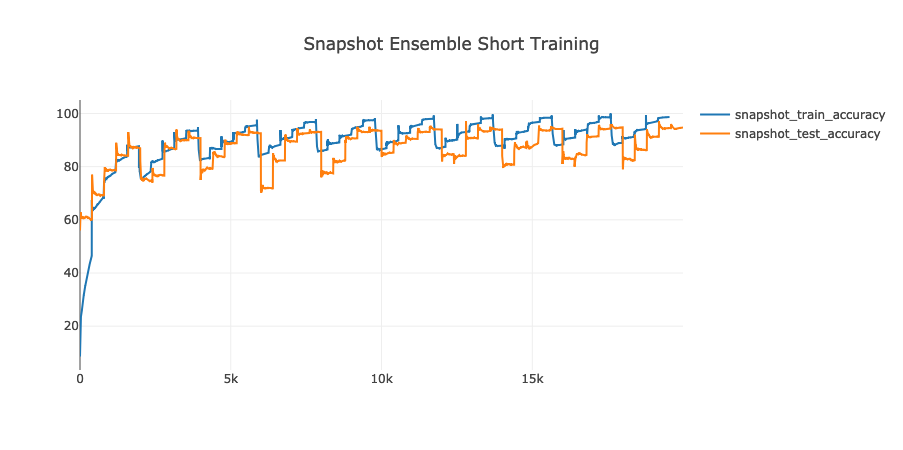

In [68]:
data = [
    go.Scatter(
        x=list(map(lambda l: l.step, snapshot_train_accs)),
        y=list(map(lambda l: l.value, snapshot_train_accs)),
        name="snapshot_train_accuracy"),
    go.Scatter(
        x=list(map(lambda l: l.step*4, snapshot_test_accs)),
        y=list(map(lambda l: l.value, snapshot_test_accs)),
        name="snapshot_test_accuracy")
]

layout = go.Layout(
    title='Snapshot Ensemble Short Training'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Snapshot Ensemble Short Training')

## Snapshot Ensemble Models

### Basic inference on data_loader

In [6]:
def infer(model, data_loader):
    model.eval()
    infer_loss = 0
    correct = 0
    total = 0
    nb_batch=0
    with torch.no_grad():
        for (inputs, targets) in data_loader:
            nb_batch+=1
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    infer_acc = 100. * correct / total
    
    return infer_acc

### Build Best models Snapshot Ensemble

In [34]:
from snapshot_ensemble import SnapshotEnsemble
from utils.rotating_checkpoint import load_best_models
from pathlib import Path

model = model.to(device)

# build snapshot ensemble from best models in cycle 9, 8, 6, 5
snapshots = SnapshotEnsemble.build_from_checkpoints(model, [9, 8, 6, 5], "snapshot_ensemble_2")

# Best single model from last cycle
snapshot_best = load_best_models(model, 1, "snapshot_ensemble_2",
                                 path=Path("./checkpoints") / "snapshot_ensemble_2" / "cycle_9")[0]                                 

Extracting best model from checkpoints/snapshot_ensemble_2/cycle_9/snapshot_ensemble_2_*.pth
Building model from checkpoints/snapshot_ensemble_2/cycle_9/snapshot_ensemble_2_1.pth
Extracting best model from checkpoints/snapshot_ensemble_2/cycle_8/snapshot_ensemble_2_*.pth
Building model from checkpoints/snapshot_ensemble_2/cycle_8/snapshot_ensemble_2_0.pth
Extracting best model from checkpoints/snapshot_ensemble_2/cycle_6/snapshot_ensemble_2_*.pth
Building model from checkpoints/snapshot_ensemble_2/cycle_6/snapshot_ensemble_2_0.pth
Extracting best model from checkpoints/snapshot_ensemble_2/cycle_5/snapshot_ensemble_2_*.pth
Building model from checkpoints/snapshot_ensemble_2/cycle_5/snapshot_ensemble_2_1.pth
Extracting best model from checkpoints/snapshot_ensemble_2/cycle_9/snapshot_ensemble_2_*.pth
Building model from checkpoints/snapshot_ensemble_2/cycle_9/snapshot_ensemble_2_1.pth


### Compute Accuracy

In [35]:
snapshot_ensemble_accuracy = infer(snapshots, test_loader)
print("Snapshot Ensemble Accuracy", snapshot_ensemble_accuracy)

snapshot_single_accuracy = infer(snapshot_best, test_loader)
print("Snapshot Single Accuracy", snapshot_single_accuracy)

Snapshot Ensemble Accuracy 93.43
Snapshot Single Accuracy 94.78


### Conclusion

For CIFAR10 which has a quite deterministic training in a quite simple complexity space, on a short training as this one, we see that taking a snapshot ensemble of last 2 cycles isn't better than taking the best model of last cycle.

In the paper, they see the power of snapshot ensemble with more complex problem like CIFAR100 and longer training (300 epochs). If I have time later, I'll test it :)

Now, let's see the difference with normal training

# Normal Training

In [36]:
lr = 0.1
epochs = 50
nb_cycles = 10
exp_name="normal_2"

In [ ]:
tensorboard_dir = str(Path("./tf_logs") / exp_name)
writer = SummaryWriter(log_dir=tensorboard_dir)

### Model

In [39]:
model = WideResNet(depth=28, num_classes=len(classes), widen_factor=10)
init_weights(model)

network initialized with kaiming weights


### Optimizer & Scheduler (classic SGD + LR Plateau)

In [40]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, verbose=False, patience=5
)

### Training Loop

In [ ]:
start_epoch = 1  # start from epoch 0 or last checkpoint epoch
model = model.to(device)

pb = ProgressBar(
    epochs,
    len(train_loader),
    destroy_on_completed=False,
    keys_to_plot=["train_loss", "test_accuracy", "best_loss", "best_acc"],
)

best_loss, best_acc = test(model, test_loader, criterion, writer, 0, log=False)

for epoch in range(start_epoch, start_epoch + epochs):
    pb.start_epoch(epoch)
    
    train_loss, train_acc = train(
        model, train_loader, criterion, optimizer, scheduler, pb, writer, epoch,
        scheduler_each_step=False
    )
    
    test_loss, test_acc = test(model, test_loader, criterion, writer, epoch)

    scheduler.step(train_loss)
    
    if best_acc < test_acc:
        print("Checkpointing...")
        best_acc = test_acc
        best_loss = test_loss
        state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "acc": best_acc,
            "loss": best_loss,
            "epoch": epoch,
        }
        rotating_save_checkpoint(state, prefix=exp_name, path="./checkpoints", nb=5)

    pb.end_epoch(
        {"test_loss": test_loss, "test_accuracy": test_acc, "best_loss": best_loss, "best_acc": best_acc}
    )    
            
        
pb.close()

### Plots

In [66]:
from utils.tensorboard import tensorboard_event_accumulator

normal_tensorboard_file = "./tf_logs/normal_2/events.out.tfevents.1552509405.b127a0f62e91"
normal_ea = tensorboard_event_accumulator(normal_tensorboard_file)

normal_train_accs = normal_ea.Scalars("train_accuracy")
normal_test_accs = normal_ea.Scalars("test_accuracy")


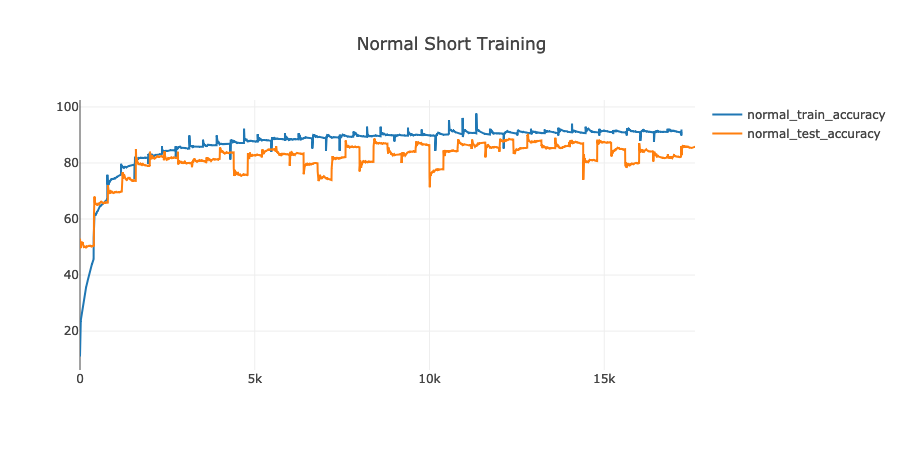

In [63]:
data = [
    go.Scatter(
        x=list(map(lambda l: l.step, normal_train_accs)),
        y=list(map(lambda l: l.value, normal_train_accs)),
        name="normal_train_accuracy"),
    go.Scatter(
        x=list(map(lambda l: l.step*4, normal_test_accs)),
        y=list(map(lambda l: l.value, normal_test_accs)),
        name="normal_test_accuracy")
]

layout = go.Layout(
    title='Normal Short Training'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Normal Short Training')

### Get Normal Best model

In [37]:
from utils.rotating_checkpoint import load_best_models

normal = load_best_models(model, 1, "normal_2")[0]

Extracting best model from checkpoints/normal_2_*.pth
Building model from checkpoints/normal_2_4.pth


In [38]:
normal_accuracy = infer(normal, test_loader)

In [39]:
print("normal_accuracy", normal_accuracy)

normal_accuracy 88.36


### Conclusion

We see that normal training is much slower to converge and reaches hardly 88.36 where cyclic cosine-annealing can reach 93-94% in the same number of epochs.

## Comparing both Trainings

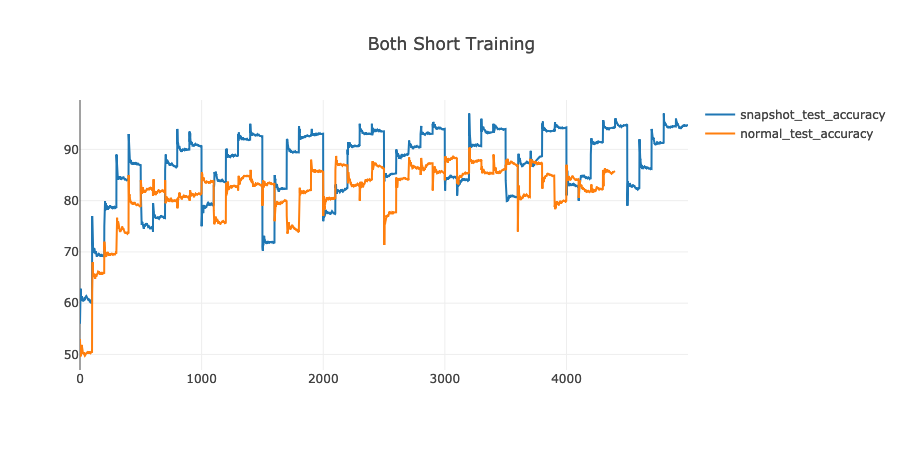

In [64]:
data = [
    go.Scatter(
        x=list(map(lambda l: l.step, snapshot_test_accs)),
        y=list(map(lambda l: l.value, snapshot_test_accs)),
        name="snapshot_test_accuracy"),
    go.Scatter(
        x=list(map(lambda l: l.step, normal_test_accs)),
        y=list(map(lambda l: l.value, normal_test_accs)),
        name="normal_test_accuracy")
]

layout = go.Layout(
    title='Both Short Training'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Both Short Training')

## Conclusion

### Cyclic Cosine Annealing scheduler for faster and better training

Cyclic Cosine Annealing scheduler with rapid learning rate decrease at each batch during training allows faster decrease of train & test loss reaching much faster a local minimum. Hard-reset of learning rate at end of cycle allows to escape this local minimum and reach another optimization path towards another local minimum that happens to be better at each cycle in the case of CIFAR10.

With it, we can reach 93-95% of accuracy quite fast while normal training never reaches 90%.

So just using this scheduler and keep best model allows faster & better accuracy under CIFAR10 than with a classic SGD/LR Scheduler in the same number of epochs.


### Snapshot Ensemble for more robust global model

Taking the best models in the last 2 or 3 cycles allows to build an ensemble of models that is more robust than the normal training best model. The best model obtained by the cyclic cosine annealing scheduler under short training and CIFAR10 complexity is still better than snapshot ensemble. But according to the paper, for more complex problems and longer trainings, snapshot ensemble should take advantage by mixing different local minima thus reducing error rates.

### Next steps

Try on a more complex problem like CIFAR100 and longer training with the exact same checkpointing as in the paper.

Anyway, this is certainly an idea to keep in mind as it's easy to use and quite efficient in single training and snapshot ensemble.